In [1]:
# %load_ext autoreload
# %autoreload 2

In [16]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

Value(False)
Value(False)


In [3]:
# Load and preprocess example images (replace with your own image paths)
# image_names = ["data/test_data/back_right_3_rgb.png", "data/test_data/front_left_3_rgb.png", "data/test_data/front_right_3_rgb.png", "data/test_data/robot_3_rgb.png"]
# images = load_and_preprocess_images(image_names).to(device)

# with torch.no_grad():
#     with torch.cuda.amp.autocast(dtype=dtype):
#         # Predict attributes including cameras, depth maps, and point maps.
#         predictions = model(images)

In [12]:
# import PIL

# print(predictions.keys())
# print(predictions['world_points'].shape)
# print(PIL.Image.open(image_names[0]).size)

dict_keys(['pose_enc', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images'])
torch.Size([1, 4, 392, 518, 3])
(640, 480)


In [7]:
import os
from PIL import Image

def resize_and_save_images_from_paths(image_path_list, target_size=518, output_dir="data/resized/images/"):
    os.makedirs(output_dir, exist_ok=True)

    processed_files_count = 0
    failed_files_info = []

    print(f"Starting image processing. Output will be saved to: {os.path.abspath(output_dir)}")

    for image_path in image_path_list:
        img = Image.open(image_path)

        width, height = img.size

        new_width = target_size
        new_height = round(height * (new_width / width) / 14) * 14

        resized_img = img.resize((new_width, new_height), Image.Resampling.BICUBIC)

        base_filename = os.path.basename(image_path)
        output_path = os.path.join(output_dir, base_filename)

        resized_img.save(output_path)
        processed_files_count += 1


    print("--- Processing Summary ---")
    print(f"Successfully processed and saved: {processed_files_count} image(s).")
    if failed_files_info:
        print(f"Failed to process: {len(failed_files_info)} image(s):")
        for item in failed_files_info:
            print(f"  - Path: {item['path']}, Reason: {item['reason']}")
    print(f"Resized images are in: {os.path.abspath(output_dir)}")

original_image_names = ["data/test_data/back_right_3_rgb.png", "data/test_data/front_left_3_rgb.png", "data/test_data/front_right_3_rgb.png", "data/test_data/robot_3_rgb.png"]
resize_and_save_images_from_paths(original_image_names)

Starting image processing. Output will be saved to: /home/danny/repos/vggt/data/images/resized
--- Processing Summary ---
Successfully processed and saved: 4 image(s).
Resized images are in: /home/danny/repos/vggt/data/images/resized


In [15]:
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
import os
import json
import numpy as np

image_names = ["data/resized/images/back_right_3_rgb.png", "data/resized/images/front_left_3_rgb.png", "data/resized/images/front_right_3_rgb.png", "data/resized/images/robot_3_rgb.png"]
images = load_and_preprocess_images(image_names).to(device)

# img_dir = 'data/extracted_frames/robot/'
# image_names = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)][:50]
# images = load_and_preprocess_images(image_names).to(device)

points = json.load(open('data/resized/annotations/robot_3_rgb_points.json'))
points = np.array(points)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)

    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]

    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)

    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0),
                                                                extrinsic.squeeze(0),
                                                                intrinsic.squeeze(0))

    # Predict Tracks
    # choose your own points to track, with shape (N, 2) for one scene
    query_points = torch.FloatTensor(points).to(device)
    # query_points = torch.FloatTensor([[100.0, 200.0],
    #                                     [60.72, 259.94]]).to(device)
    track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])

Value(False)


In [12]:
print(aggregated_tokens_list[0].shape)
print(point_map.shape)
print(point_map_by_unprojection.shape)

torch.Size([1, 4, 1041, 2048])
torch.Size([1, 4, 392, 518, 3])
(4, 392, 518, 3)


In [ ]:
from vggt.utils.visual_track import visualize_tracks_on_images

track = track_list[-1]
visualize_tracks_on_images(images, track, (conf_score>0.2) & (vis_score>0.2), out_dir="track_visuals")




In [4]:
from utils.video import get_and_save_video_frames

get_and_save_video_frames("data/test_videos/camera_front_right.mp4", "data/extracted_frames/front_right/frames", fps=5)



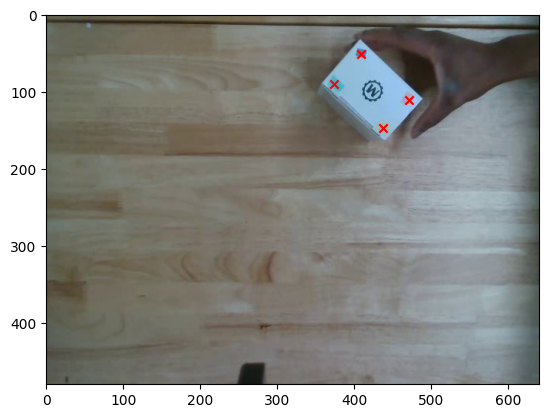

In [13]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import json

def plot_points(points, image):
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='red', marker='x')
    plt.show()


img_name = 'data/extracted_frames/robot/frame_82.png'
image = cv2.imread(img_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points = json.load(open('data/extracted_frames/frame_82_points.json'))
points = np.array(points)
plot_points(points, image)


In [ ]:
from vggt.heads.track_modules.base_track_predictor import BaseTrackerPredictor
from vggt.heads.track_modules.utils import sample_features4d, bilinear_sampler
from vggt.heads.dpt_head import DPTHead

dim_in = 2048
patch_size=14
features=128
iters=4
predict_conf=True
stride=2
corr_levels=7
corr_radius=4
hidden_size=384
pos_embed=True

feature_extractor = DPTHead(
    dim_in=dim_in,
    patch_size=patch_size,
    features=features,
    feature_only=True,
    down_ratio=2,
    pos_embed=pos_embed
)

tracker = BaseTrackerPredictor(
    latent_dim=features,
    predict_conf=predict_conf,
    stride=stride,
    corr_levels=corr_levels,
    corr_radius=corr_radius,
    hidden_size=hidden_size
)

feature_extractor.eval()


